In [4]:
import casadi as ca
import sys
sys.path.insert(0, '../python/pyecca')

import matplotlib.pyplot as plt
from pyecca.util import rk4
import numpy as np

from casadi.tools.graph import dotgraph 
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())


In [17]:
def numerical(x_end, n_x):
    """
    Edit this function and setup an optimal control problem that minimizes the time
    it takes for a ball rolling a long a curve to reach the end of the path assuming it
    starts at a height of 1 m and ends at a height of 0 m and the length of the path is
    x_end m.
    """
    x = np.linspace(0, x_end, n_x)  # x position where path changes
    dx = x[1] - x[0]  # path steps width
    n_dy = n_x - 1  # number of height changes we need to find
    dy0 = -(1/n_dy)*np.ones(n_dy)  # initial guess for height change along path
    dy_vect = ca.SX.sym('dy_vect', n_dy)
    
    #def objective(dy_vect):
    t = 0;
    y = 1;
    g = 9.81;
    dx = x_end/n_dy

    for i in range(n_dy):
        dy = dy_vect[i]
        d = ca.sqrt(dx**2 + dy**2)
        vbar = (ca.sqrt(2*g*(1 - y))
                + ca.sqrt(2*g*(1 - (y+dy))))/ 2
        y += dy
        t += d/vbar
    y_final = y
    t_final = t
        #return t_final
    
    #time = objective(dy_vect)
    nlp = {'x':dy_vect, 'f':t_final, 'g': y_final}
    S = ca.nlpsol('S', 'ipopt', nlp)
    result = S(x0=dy0, lbg=0, ubg=0)
    x_opt = result['x']
    
    dy_opt = x_opt # TODO, find optimal change in y along path
    y_opt = ca.vertcat(1, 1 + np.cumsum(dy_opt))
    return x, y_opt

In [18]:
# NLP declaration to solve for boundary condition of brachistochrone
def analytical(x_end, n_x):
    c = ca.SX.sym('c')
    theta_f = ca.SX.sym('theta_f')
    xf = c*(theta_f - np.sin(theta_f))
    yf = 1 - c*(1 - np.cos(theta_f))

    nlp = {'x':ca.vertcat(c, theta_f), 'f':0,'g':ca.vertcat(xf-x_end,yf)}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    res = S(x0=(1, np.pi), lbg=(0, 0), ubg=(0, 0))
    C_opt = float(res['x'][0])
    theta_f_opt = float(res['x'][1])
    theta = np.linspace(0, theta_f_opt, n_x)
    xa = C_opt*(theta - np.sin(theta))
    ya = 1 - C_opt*(1 - np.cos(theta))
    return xa, ya

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4950

Total number of variables............................:       99
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

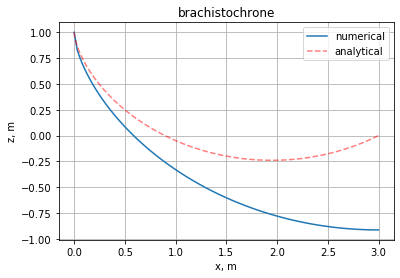

In [19]:
n_x = 100  # number of points for approximation of path
x_end = 3  # final x position when height is zero

# analytical solution
xa, ya = analytical(x_end=x_end, n_x=n_x)

# numerical solution
x, y_opt = numerical(x_end=x_end, n_x=n_x)

# plot
plt.title('brachistochrone')
plt.plot(x, y_opt, label='numerical')
plt.plot(xa, ya, 'r--', label='analytical', alpha=0.5)
plt.grid(True)
plt.xlabel('x, m')
plt.ylabel('z, m')
plt.legend()